# Index Tracking with Portfolio Optimization under Cardinality and Buy-in Constraints using Portfolio Safeguard (PSG) Solver
---

> ## By: Amos Anderson

---

### Background and Objective

The Dow Jones Industrial Average (^DJI) is a price-weighted index of 30 stocks of large U.S. companies across various sectors. 

> In our replication problem, we shall use the ^DJI index as the benchmark index.

The aim of project is to replicate the Dow Jones Industrial Average using a constructed portfolio of stocks, under buy-in, cardinality and
budget constraints, and to evaluate how closely the portfolio tracks the index over a given in-sample period.

Specifically, we seek to:

1. Minimize tracking error between the replicating portfolio and the Dow Jones index.

    That is, choose portfolio weights (or dollar positions) so that the portfolio return series follows the index return series as closely as possible.

2. Incorporate practical constraints including:

    - Cardinality constraint (limit on number of assets in the portfolio) so as to produce simplified, realistic portfolios (e.g. not holding all 50, but some smaller subset).

    - Buy-in constraint (minimum investment per asset) so that each selected asset has a nontrivial position, avoiding extremely small or negligible holdings.

    - Budget constraint so that the total funds allocated equal a fixed budget (often normalized to 1, or dollar budget) so the portfolio is fully invested (or within allowed bounds).

3. Use Portfolio Safeguard (PSG) to solve this optimization problem, leveraging its capability to handle mixed-integer constraints (cardinality, buy-in) and risk tracking objectives.

4. As a verification, compare the value paths of the replicating portfolio and the Dow Jones index (assuming both start at an initial value of 100) over the in-sample period, to see how well the portfolio tracks the index without rebalancing.

In [1]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.insert(1, os.path.join(os.environ.get('PSG25_HOME'), 'Python'))
from psg_preload_libraries import initialize_psg_environment
initialize_psg_environment()
import psgpython as psg
import matplotlib.pyplot as plt

### Data Acquisition and Preprocessing

In [2]:
path_to_data = r"C:\Users\amosa\Documents\My Graduate School\FALL 2025\Courses\AMS 518_Advanced Stochastic Models, Risk Assessment, and Portfolio Optimization\Assignments\Assignment 2\Assignment Resources"

dow_index_close_prices = pd.read_csv(os.path.join(path_to_data, 'dow_index_close_prices.csv')).set_index("Date")
dow_index_daily_log_returns = pd.read_csv(os.path.join(path_to_data, 'dow_index_daily_log_returns.csv')).set_index("Date")
stocks_50_close_prices = pd.read_csv(os.path.join(path_to_data, 'stocks_50_close_prices.csv')).set_index("Date")
stocks_50_daily_log_returns = pd.read_csv(os.path.join(path_to_data, 'stocks_50_daily_log_returns.csv')).set_index("Date")

In [3]:
initial_budget = 100
gamma = 0.06

normalized_stocks_50_daily_log_returns = stocks_50_daily_log_returns / (initial_budget*(1 - gamma))

normalized_stocks_50_daily_log_returns

,AAPL,MSFT,AMZN,GOOGL,META,NVDA,TSLA,BRK-B,JPM,JNJ,...,QCOM,TXN,HON,IBM,ORCL,CAT,UPS,BA,GS,MS
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-15,0.000017,0.000173,0.000181,0.000184,0.000248,0.000098,0.000738,-0.000048,-0.000336,0.000039,...,0.000289,0.000161,-0.000011,0.000030,0.000262,-0.000346,0.000092,-0.000120,-0.000178,-0.000159
2020-09-16,-0.000319,-0.000192,-0.000266,-0.000161,-0.000353,-0.000398,-0.000191,0.000032,0.000045,-0.000035,...,-0.000186,-0.000073,0.000107,0.000154,-0.000089,0.000178,-0.000110,0.000255,0.000143,0.000159
2020-09-17,-0.000171,-0.000112,-0.000242,-0.000178,-0.000357,-0.000043,-0.000451,-0.000075,-0.000122,-0.000089,...,0.000030,0.000055,0.000021,0.000060,-0.000044,0.000193,-0.000008,0.000004,-0.000315,-0.000189
2020-09-18,-0.000343,-0.000133,-0.000192,-0.000260,-0.000096,-0.000237,0.000460,0.000008,-0.000023,0.000144,...,-0.000395,-0.000133,-0.000103,-0.000186,-0.000076,-0.000103,-0.000006,-0.000414,0.000002,-0.000036
2020-09-21,0.000318,0.000114,0.000020,-0.000155,-0.000186,0.000282,0.000173,-0.000256,-0.000334,-0.000295,...,0.000118,-0.000130,-0.000473,-0.000220,0.000189,-0.000505,0.000093,-0.000321,-0.000047,-0.000372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-05,-0.000004,-0.000275,-0.000152,0.000123,0.000054,-0.000292,0.000380,-0.000151,-0.000336,-0.000020,...,0.000009,0.000036,-0.000045,0.000058,0.000458,0.000072,0.000070,-0.000053,-0.000153,-0.000174
2025-09-08,-0.000081,0.000069,0.000160,-0.000034,-0.000002,0.000082,-0.000135,-0.000128,-0.000053,-0.000018,...,0.000027,-0.000120,0.000025,0.000319,0.000256,-0.000008,-0.000090,0.000062,0.000052,0.000050
2025-09-09,-0.000159,0.000004,0.000108,0.000251,0.000188,0.000154,0.000017,-0.000023,0.000178,-0.000070,...,-0.000105,-0.000045,-0.000027,0.000125,0.000134,-0.000119,0.000010,-0.000066,0.000312,0.000242


### Extended Design Matrix

In [4]:
combined_df = normalized_stocks_50_daily_log_returns.copy()

combined_df['scenario_benchmark'] = dow_index_daily_log_returns

headers = combined_df.columns.tolist()
track_port_matrix_body = np.column_stack([combined_df[str(h)].to_numpy() for h in headers])
track_port_matrix = [headers, track_port_matrix_body]

track_port_matrix

[['AAPL',
  'MSFT',
  'AMZN',
  'GOOGL',
  'META',
  'NVDA',
  'TSLA',
  'BRK-B',
  'JPM',
  'JNJ',
  'V',
  'PG',
  'UNH',
  'MA',
  'HD',
  'XOM',
  'PFE',
  'BAC',
  'KO',
  'DIS',
  'NFLX',
  'AVGO',
  'CSCO',
  'ADBE',
  'TMO',
  'NKE',
  'WMT',
  'INTC',
  'PEP',
  'ABBV',
  'ABT',
  'CRM',
  'ACN',
  'AMD',
  'COST',
  'LIN',
  'MCD',
  'CVX',
  'VZ',
  'T',
  'QCOM',
  'TXN',
  'HON',
  'IBM',
  'ORCL',
  'CAT',
  'UPS',
  'BA',
  'GS',
  'MS',
  'scenario_benchmark'],
 array([[ 1.65861702e-05,  1.73117447e-04,  1.80711809e-04, ...,
         -1.77957128e-04, -1.59254681e-04,  8.10700000e-05],
        [-3.18701915e-04, -1.91777872e-04, -2.66320213e-04, ...,
          1.43028511e-04,  1.59254681e-04,  1.31296000e-03],
        [-1.71195106e-04, -1.11610319e-04, -2.42494681e-04, ...,
         -3.14727128e-04, -1.88851277e-04, -4.66263000e-03],
        ...,
        [-1.59049043e-04,  4.48308511e-06,  1.07712766e-04, ...,
          3.11872553e-04,  2.42457234e-04,  4.30558000e-03],
 

### Constraints

In [15]:
cardn_constraint = [headers[:-1], np.full(50, 1.000000000000e+000).reshape(1,50)]
buyin_constraint = [headers[:-1], np.full(50, 1.979012345178e+003).reshape(1,50)]
poly_row1 = np.full(50, 1.000000000000e+000) 
poly_row2 = np.array([
    1.454372622591e+005, 1.979012345178e+005, 1.457831324254e+005,
    1.753012048281e+005, 1.460063899063e+005, 1.321576763202e+005,
    1.551351351246e+005, 1.185383243772e+005, 1.318181819579e+005,
    4.801980192552e+005, *([0.0] * 40)  
])

poly_constraint = [headers[:-1], np.vstack([poly_row1, poly_row2])]

In [16]:
poly_constraint

[['AAPL',
  'MSFT',
  'AMZN',
  'GOOGL',
  'META',
  'NVDA',
  'TSLA',
  'BRK-B',
  'JPM',
  'JNJ',
  'V',
  'PG',
  'UNH',
  'MA',
  'HD',
  'XOM',
  'PFE',
  'BAC',
  'KO',
  'DIS',
  'NFLX',
  'AVGO',
  'CSCO',
  'ADBE',
  'TMO',
  'NKE',
  'WMT',
  'INTC',
  'PEP',
  'ABBV',
  'ABT',
  'CRM',
  'ACN',
  'AMD',
  'COST',
  'LIN',
  'MCD',
  'CVX',
  'VZ',
  'T',
  'QCOM',
  'TXN',
  'HON',
  'IBM',
  'ORCL',
  'CAT',
  'UPS',
  'BA',
  'GS',
  'MS'],
 array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 1.0000

#### Solving the Optimization with PSG

In [17]:
# PSG Optimization set up

allowExternal = True
suppressMessages = False

# Problem Statement
problem_name = "problem_index_tracking"

problem_statement = "minimize \n\
  max_risk(matrix_inmmax) \n\
Constraint: <= 50 \n\
  cardn_pos(0.01, matrix_ksi) \n\
Constraint: <= 0 \n\
  buyin_pos(0.01, matrix_ksibuy) \n\
Constraint: <= 100 \n\
  linear(matrix_ksi) \n\
  +variable(trcost) \n\
Constraint: <= 94 \n\
  variable(trcost) \n\
Constraint: <= 0 \n\
  -variable(trcost) \n\
  +0.01*polynom_abs(matrix_ksipol) \n\
  +100*cardn_pos(0.01, matrix_ksipol) \n\
  +100*cardn_neg(0.01, matrix_ksipol) \n\
Box: >= 0 \n\
Solver: CAR, precision = 3, stages = 3"

problem_dictionary_indx_track = {'problem_name':problem_name, 'problem_statement':problem_statement,
                        'matrix_inmmax' : track_port_matrix,
                        'matrix_ksi' : cardn_constraint, 
                        'matrix_ksibuy' : buyin_constraint,
                        'matrix_ksipol' : poly_constraint}

result = psg.psg_solver(problem_dictionary_indx_track, allowExternal, suppressMessages)

Running solver
Reading problem formulation
Asking for data information
Getting data
      2.0% of scenarios is processed
100% of matrix_inmmax was read
100% of matrix_ksi was read
100% of matrix_ksibuy was read
100% of trcost was read
100% of matrix_ksipol was read
Start optimization
Ext.iteration=32  Objective=0.626642830296E-01  Residual=0.959435545878E+04
Start stage  1
Ext.iteration=11  Objective=0.626642830296E-01  Residual=0.964435725958E+04
Start stage  2
Ext.iteration=11  Objective=0.658522757761E-01  Residual=0.959486034395E+04
Start stage  3
Ext.iteration=11  Objective=0.658522757761E-01  Residual=0.959486003222E+04
Polishing      1
Ext.iteration=11  Objective=0.658522757761E-01  Residual=0.959486003222E+04
Polishing      2
Ext.iteration=11  Objective=0.658516317463E-01  Residual=0.964486012164E+04
Polishing      3
Ext.iteration=11  Objective=0.658516317463E-01  Residual=0.964486013222E+04
Polishing      4
Ext.iteration=11  Objective=0.680116535867E-01  Residual=0.96453654439

#### Optimization Results

In [18]:
# Optimal ouput
result['output']

['Problem: problem_1, solution_status = infeasible',
 'Timing: data_loading_time = 0.28, preprocessing_time = 0.02, solving_time = 0.14',
 'Variables: optimal_point = point_problem_1',
 'Objective: objective = 412.736322112 [412.673657829]',
 'Constraint: constraint_1 =  3.000000000000E+00 [-4.700000000000E+01]',
 'Constraint: constraint_2 =  0.000000000000E+00 [ 0.000000000000E+00]',
 'Constraint: constraint_3 =  6.120902612131E+05 [ 6.119902612131E+05]',
 'Constraint: constraint_4 =  7.400000000000E+01 [-2.000000000000E+01]',
 'Constraint: constraint_5 =  1.318860419759E+04 [ 1.318860419759E+04]',
 'Function: max_risk(matrix_inmmax) =  4.127363221115E+02',
 'Function: cardn_pos(1.E-02,matrix_ksi) =  3.000000000000E+00',
 'Function: buyin_pos(1.E-02,matrix_ksibuy) =  1.000000000000E+00',
 'Function: linear(matrix_ksi) =  6.120162612131E+05',
 'Function: variable(trcost) =  7.400000000000E+01',
 'Function: polynom_abs(matrix_ksipol) =  1.216260419759E+06',
 'Function: cardn_pos(1.E-02,

In [19]:
# Optimal allocations
result['point_problem_1']

[['aapl',
  'msft',
  'amzn',
  'googl',
  'meta',
  'nvda',
  'tsla',
  'brk-b',
  'jpm',
  'jnj',
  'v',
  'pg',
  'unh',
  'ma',
  'hd',
  'xom',
  'pfe',
  'bac',
  'ko',
  'dis',
  'nflx',
  'avgo',
  'csco',
  'adbe',
  'tmo',
  'nke',
  'wmt',
  'intc',
  'pep',
  'abbv',
  'abt',
  'crm',
  'acn',
  'amd',
  'cost',
  'lin',
  'mcd',
  'cvx',
  'vz',
  't',
  'qcom',
  'txn',
  'hon',
  'ibm',
  'orcl',
  'cat',
  'ups',
  'ba',
  'gs',
  'ms',
  'trcost'],
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.31818202e+05, 4.80198039e+05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.

In [30]:
# Optimal Tracking Portfolio Results

print("Optimal positions in tracking portfolio : \n", result['point_problem_1'][1] )
print()
print("\nTotal non-zero positions in tracking portfolio : \n", (result['point_problem_1'][1] > 0).sum()-1)
print()
print("\nValue of Transaction cost at the optimal solution : \n", result['output'][13])
print()
print("\nOptimal value of Maximum Absolute Error : \n", result['output'][9])

Optimal positions in tracking portfolio : 
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.31818202e+05 4.80198039e+05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.00000000e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.40000000e+01]


Total non-zero positions in tracking portfolio : 
 3


Value of Transaction cost at the optimal solution : 
 Function: variable(trcost) =  7.400000000000E+01


Optimal value o

In [31]:
pos_df = pd.DataFrame({
    'Ticker': headers[:len(result['point_problem_1'][1])-1], 
    'Position': np.array(result['point_problem_1'][1][:-1], dtype=float)
})

# Which tickers were selected (non-zero)
selected = pos_df[pos_df.Position != 0].copy()
print("\nSelected tickers (non-zero):")
print(selected)

# Sort by position for quick inspection
pos_df_sorted = pos_df.reindex(pos_df.Position.abs().sort_values(ascending=False).index)
print("\nSorted nonzero positions:")
print(pos_df_sorted[pos_df_sorted.Position > 0].head(50))


Selected tickers (non-zero):
   Ticker       Position
8     JPM  131818.201958
9     JNJ  480198.039255
43    IBM       0.020000

Sorted nonzero positions:
   Ticker       Position
9     JNJ  480198.039255
8     JPM  131818.201958
43    IBM       0.020000


#### Verification using Benchmark

In [46]:
# PSG solved optimal positions in tracking
opt_positions = pos_df['Position'].to_numpy()

# Log return of assets (before rebalancing: all 50 stocks)
log_ret_mat = stocks_50_daily_log_returns.astype(float).to_numpy()
cum_log_ret = np.cumsum(log_ret_mat, axis=0)                    # sum from i=1 to i=50 of log_returns
cum_simple_returns = np.exp(cum_log_ret) - 1.0                  # SimpleCumReturn = e^{CumLogRet} - 1

# Value of each position and portfolio value at time t:
## V_{i,t} = position_{i}*(1+SimpleCumRet_{i,t}) = position_{i}*e^{CumLogRet}
pos_values_over_time = cum_simple_returns * opt_positions + opt_positions
## V_{t} = sum_{i=1}^{i=50} V_{i,t}
portfolio_value = pos_values_over_time.sum(axis=1)
## Scaled portfolio value to start at 100: Scaled V = 100* V_{t} / V_{0}
portfolio_value_scaled = 100.0 * portfolio_value / portfolio_value[0]

# Similarly, for the benchmark index
# Log return of ^GJI
index_log_ret = dow_index_daily_log_returns['^DJI'].astype(float).to_numpy()
## Cumulative log for ^GJI = sum_{s=1}^{t} ^GJI log returns for 1<= s<= t <=T
index_cum = np.cumsum(index_log_ret.astype(float))
## ^GJI index value scaled to start from 100: I_{t} = 100*e^{IndexCumLogRet_{t} - IndexCumLogRet_{0}}
index_value = np.exp(index_cum)
index_value_scaled = 100 * index_value / index_value[0]

# Time series of Scaled Replicating Portfolio and Scaled Benchmark Index
portfolio_series = pd.Series(portfolio_value_scaled, index = stocks_50_daily_log_returns.index, name='Replicating_Portfolio')
index_series = pd.Series(index_value_scaled, index = stocks_50_daily_log_returns.index, name='DJI')  

# Quick inspect
print(portfolio_series.iloc[:5])
print(index_series.iloc[:5])

Date
2020-09-15    100.000000
2020-09-16     99.828462
2020-09-17     98.934859
2020-09-18     99.957726
2020-09-21     97.150068
Name: Replicating_Portfolio, dtype: float64
Date
2020-09-15    100.000000
2020-09-16    100.131382
2020-09-17     99.665593
2020-09-18     98.792025
2020-09-21     96.971308
Name: DJI, dtype: float64


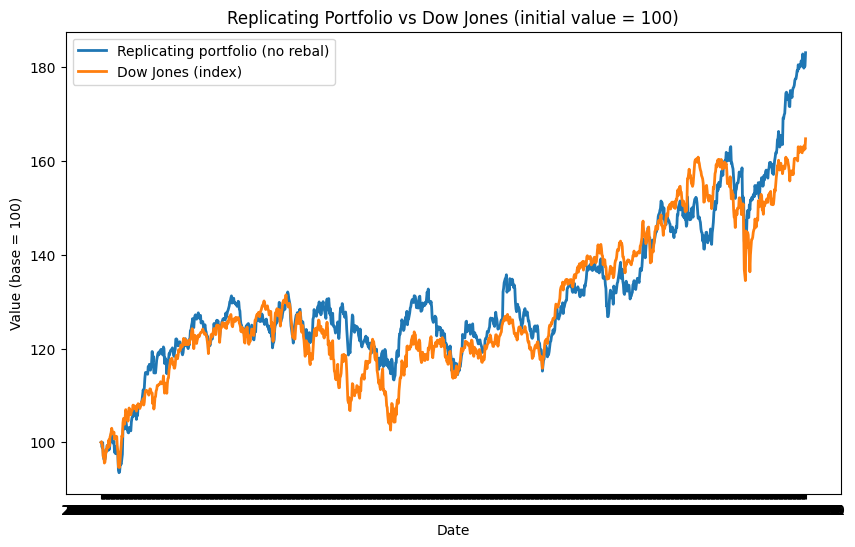

In [47]:
plt.figure(figsize=(10,6))
plt.plot(portfolio_series.index, portfolio_series.values, label='Replicating portfolio (no rebal)', linewidth=2)
plt.plot(index_series.index, index_series.values, label='Dow Jones (index)', linewidth=2)
plt.title('Replicating Portfolio vs Dow Jones (initial value = 100)')
plt.xlabel('Date')
plt.ylabel('Value (base = 100)')
plt.legend()
plt.show()